# Monte Carlo Simulation - Advanced

In this homework, we will work with the Lennard Jones equation added with cutoff distance and periodic boundary conditions.

$$ U(r) = 4 \epsilon \left[\left(\frac{\sigma}{r}\right)^{12} -\left(\frac{\sigma}{r}\right)^{6} \right] $$ 
Reduced units:
$$ U^*\left(r^*_{ij} \right) = 4 \left[\left(\frac{1}{r^*_{ij}}\right)^{12} -\left(\frac{1}{r^*_{ij}}\right)^{6} \right] $$ 

In [5]:
import math, os
import matplotlib.pyplot as plt

%matplotlib notebook

def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.
    
    Computes the pairwise Lennard Jones interaction energy based on the separation distance in reduced unites.
    
    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
        
    Returns
    -------
    pairwise_energy : float
        The pairwise Lennard Jones interaction energy in reduced units.
    
    """
    
    r6_term = math.pow(1/r_ij,6)
    r12_term = math.pow(r6_term,2)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    ax.plot(r_ij,pairwise_energy,'ob')
    
    return pairwise_energy

In [6]:
def calculate_distance(coord1,coord2,box_length=None):
    """
    Calculate the distance between two 3D coordinates.
    
    Parameters
    ----------
    coord1, coord2 : list
        The atomic coordinates [x, y, z]
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
    
    Returns
    -------
    distance : float
        The distance between the two atoms.
    """
    distance = 0
    vector = [0,0,0]
    for i in range(3):
        vector[i] = coord1[i] -coord2[i]
        if box_length is None:
            pass
        else:
            if vector[i] > box_length/2:
                vector[i] -= box_length
            elif vector[i] < -box_length/2:
                vector[i] += box_length
        dim_dist = vector[i] ** 2
        distance += dim_dist
    distance = math.sqrt(distance)
    return distance

# Tail Correction
Truncating interactions using a cutoff removes contribution to the potential energy that might be non-negligible. The tail correction for our system makes a correction for use of the cutoff. We only have to calculate this once at the start of our simulation. The formula is:

$$U_{tail} = \frac{8\pi N^2}{3V} \epsilon \sigma ^3 \left[\frac{1}{3}\left(\frac{\sigma}{r_c}\right)^9 - \left(\frac{\sigma}{r_c}\right)^3\right]$$

In reduced units:

$$U_{tail} = \frac{8\pi N^2}{3V} \left[\frac{1}{3}\left(\frac{1}{r_c}\right)^9 - \left(\frac{1}{r_c}\right)^3\right]$$

In [7]:
def calculate_tail_correction(cutoff, box_length, num_atoms):
    """
    Calculate the tail correction.
    
    Parameters
    ----------
    cutoff : float
        The curoff distance.
        
    box_length : float
        The length of the cell.
       
    num_atoms : int
        Number of atoms in a given system.
       
    Returns
    -------
    tail_co_LJ : float
        A float number that shows the value of tail correction energy for the given system.
    """
    
    tail_co_LJ = 0
    
    coeff = 0
    
    r3 = math.pow(1/cutoff,3)
    r9 = math.pow(r3,3)
    
    coeff = 8 * math.pi * (num_atoms ** 2)/(3 * (box_length ** 3))

    tail_co_LJ = coeff * (r9/3 - r3)
    
    return tail_co_LJ

In [8]:
def calculate_total_energy(coordinates, cutoff=3, box_length=None):
    """
    Calculate the total Lennard Jones energy of a system of particles.
    
    Parameters
    ----------
    coordinates : list
        Nested list containing particle coordinates.
        
    cutoff : float
        A criteria distance for intermolecular interaction truncation
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
        
    Returns
    -------
    total_energy : float
        The total pairwise Lennard Jones energy of the system of particles.
    """
    
    total_energy = 0
    
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1,num_atoms):
            
            # print(F'Comparing atom number {i} with atom number {j}')
            
            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length)
            
            if dist_ij < cutoff:
                interaction_energy = calculate_LJ(dist_ij)
                total_energy += interaction_energy
            
    return total_energy

In [9]:
def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length

<IPython.core.display.Javascript object>


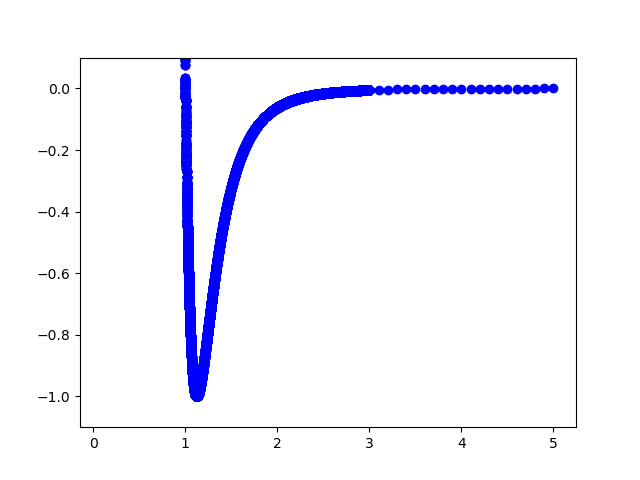

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
plt.ylim(-1.1,0.1)
for i in range(1, 51):
    r = i * 0.1
    calculate_LJ(r)

From this graph, it is obvious that when $r^*_{ij}$ > 3, the pairwise energy is almost 0 and the energy curve reaches a plateau. The general set of cutoff distance at 3$\sigma$ is reasonable.

In [11]:
assert calculate_LJ(1) == 0
assert calculate_LJ(math.pow(2,(1/6))) == -1

In [12]:
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
calculate_total_energy(coordinates)

-3487.454232861954

In [13]:
calculate_total_energy(coordinates,box_length=10)

-4351.540194543858

In [14]:
assert abs(calculate_total_energy(coordinates,box_length=10) - (-4351.5)) < 0.1